In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from string import punctuation
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torchvision
import spacy
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string

In [2]:
data = pd.read_json('raw_data.json')

In [3]:
data.head(2)

,brand_id,raw_text
0,unknown,CPL Loading Done OK Trading Perpetual Spot T...
1,roblox,BloxFarm - Earn Your Robux Today! Login to Bl...


In [4]:
data.shape

(76069, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76069 entries, 0 to 76068
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand_id  76069 non-null  object
 1   raw_text  76069 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
data.isnull().sum()

brand_id    0
raw_text    0
dtype: int64

In [7]:
# 1031 unique classes

brand_id_count = pd.DataFrame(data['brand_id'].value_counts()).reset_index().rename(columns={'brand_id':'brand_id_count', 'index':'brand_id'})
brand_id_count[brand_id_count['brand_id_count'] == 1]

,brand_id,brand_id_count
779,bain_capital,1
780,amfirst,1
781,del_one,1
782,trumark_financial_credit_union,1
783,symantec_vip,1
...,...,...
1026,orange_county_s_credit_union,1
1027,credit_union_west,1
1028,spark_nz,1
1029,absa,1


In [8]:
# join the count on the brand id
data = pd.merge(data, brand_id_count, on='brand_id', how='inner')

In [9]:
data.head(2)

,brand_id,raw_text,brand_id_count
0,unknown,CPL Loading Done OK Trading Perpetual Spot T...,17882
1,unknown,Home Page - aflac.sparkfly.com iframe srcwwwg...,17882


unknown means something that is not associated with any major brand, a random piece of text hosted on a website

In [10]:
# seeing what an unknown class looks like

data[data['brand_id'] == 'unknown']['raw_text'][0]

'CPL  Loading Done  OK Trading Perpetual Spot Trading Markets Assets Liquidity Mining Help Center Bulletin APP Download  Download Login Register Language English   Spanish English  Register Login Choose language Convert currency CPL The Most Secure Cryptocurrency Trading Platform 6448013135USD 24hour trading volume 30 Integrated liquidity providers 2000000 Users Sign up now CPL option trading system maintenance announcement More Currency Pairs Latest Price 24H Change 24H Vol 24H Turnover Markets BTC  USDT 230934 230934 01347 01347 10845K 250B ETH  USDT 158218 158218 01987 01987 13155K 20776M DOGE  USDT 009206 009206 42343 42343 113B 10535M LTC  USDT 9603 9603 20512 20512 69923K 6745M ADA  USDT 03821 03821 20759 20759 Loading 1551M TRX  USDT 006237 006237 03056 03056 Loading 1481M FIL  USDT 5138 5138 17403 17403 Loading 1205M LINK  USDT 6842 6842 15823 15823 Loading 991M EOS  USDT 1033 1033 28222 28222 Loading 842M USDC  USDT 09999 09999 001 001 Loading 561M DASH  USDT 5978 5978 07471 0

In [11]:
# seeing what an non-unknown class looks like

data[data['brand_id'] == 'roblox']['raw_text'][17885]

'Roblox Robux Generator 2022  Account Information Enter your username Platform Android iOS PC Android Android iOS PC Continue Roblox Robux Generator You can safely use Roblox Generator to add Unlimited Robux to your Roblox account This is the official Roblox Robux Generator updated for 2022 Generator is easy to use Just Enter your username and select how much Robux you want to add in your account Robux Amount 1000 MAX AMOUNT 1000 5000 25000 50000 100000 20 Generate Processing Human Verification  Complete ONE offer After completion your robux will be send to your account Verify Now Account Username Selected Platform Robux Amount 0 1 Recent Activity Suadero on PC 50000 Robux Ermes Posted a minute ago Thank you it really works  Adelia Conti Posted a minute ago Once again I got all resources D I cant thank you enough 3 Abelardo Posted few seconds ago wow this website is giving some real stuff  D Add a new comment Post To prevent spam commenting is only allowed for users who already used ou

In [12]:
# comparing avg length of unknown vs avg length of non-unknowns

avg_len_text_unknown = data[data['brand_id'] == 'unknown']['raw_text'].apply(lambda x: len(x)).mean()
avg_len_text_not_unknown = data[data['brand_id'] != 'unknown']['raw_text'].apply(lambda x: len(x)).mean()

print('Average length of text with class unknown: ', round(avg_len_text_unknown,3))
print('Average length of text with class non-unknown: ', round(avg_len_text_not_unknown,3))

Average length of text with class unknown:  4540.652
Average length of text with class non-unknown:  3842.516


In [13]:
data['length_raw_text'] = data['raw_text'].apply(lambda x: len(x))

In [14]:
# the frewucny dashboard can be updated regularly to see what website is having the most traffic or for a brand use case visualize the daily traffic on web

data['brand_id_count'].describe(percentiles=[0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])

count    76069.000000
mean      7763.082898
std       7160.162808
min          1.000000
0%           1.000000
1%           4.000000
10%         58.000000
25%        395.000000
50%       7659.000000
75%      13000.000000
90%      17882.000000
99%      17882.000000
100%     17882.000000
max      17882.000000
Name: brand_id_count, dtype: float64

In [15]:
def map_brand_freqeuncy(x):
    if x <= 58:
        return 'Low'
    elif x > 58 and x <= 7659:
        return 'Medium'
    elif x > 7659 and x < 17882:
        return 'High'
    else:
        return 'unknown_very_high'
      
data['brand_freq_cat'] = data['brand_id_count'].apply(map_brand_freqeuncy)

In [16]:
data['length_raw_text_log_scaled'] = np.log10(data['length_raw_text'])

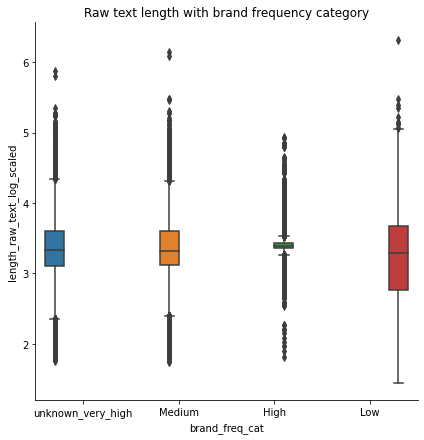

In [17]:
sns.catplot(y='length_raw_text_log_scaled', x='brand_freq_cat', hue='brand_freq_cat',
            data=data, height=6, kind="box")
plt.title('Raw text length with brand frequency category')
plt.show()

In [18]:
data['length_raw_text'].describe()

count    7.606900e+04
mean     4.006631e+03
std      1.295899e+04
min      2.800000e+01
25%      1.333000e+03
50%      2.280000e+03
75%      3.718000e+03
max      2.089116e+06
Name: length_raw_text, dtype: float64

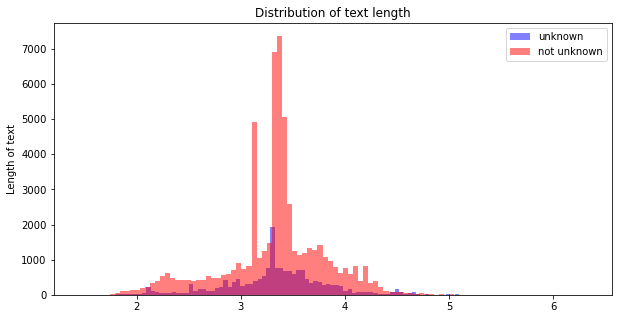

In [19]:
# distribution of length of text
data['length_raw_text'] = data['raw_text'].apply(lambda x: len(x))

# histogram

kwargs = dict(alpha=0.5, bins=100)
plt.figure(figsize=(10, 5))
plt.hist(data[data['brand_id'] == 'unknown']
         ['length_raw_text_log_scaled'], **kwargs, color='blue', density=False, label='unknown')
plt.hist(data[data['brand_id'] != 'unknown']
         ['length_raw_text_log_scaled'], **kwargs,  color='red', density=False, label='not unknown')
plt.legend()
plt.ylabel('Length of text')
plt.title('Distribution of text length')
plt.show()


In [20]:
# presence of numeric data

data['numeric_count'] = data['raw_text'].apply(lambda x: sum(c.isdigit() for c in x))

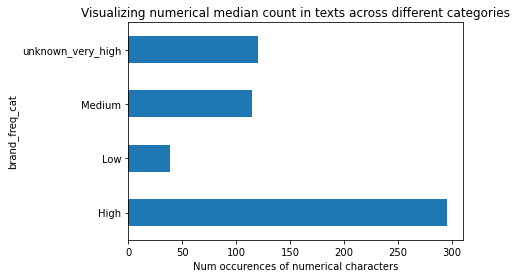

In [21]:
data.groupby('brand_freq_cat').median()['numeric_count'].plot.barh()
plt.xlabel('Num occurences of numerical characters')
plt.title('Visualizing numerical median count in texts across different categories')
plt.show()

In [22]:
def count_puncts(x):
    count = sum([1 for i in x if i in punctuation]) 
    return count

data['punctuation_count'] = data['raw_text'].apply(lambda x: count_puncts(x))

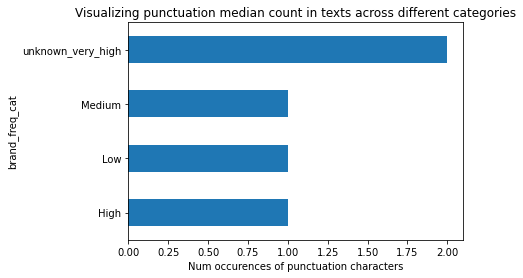

In [23]:
# can remove punctuation as it is not making much difference in data

data.groupby('brand_freq_cat').median()['punctuation_count'].plot.barh()
plt.xlabel('Num occurences of punctuation characters')
plt.title('Visualizing punctuation median count in texts across different categories')
plt.show()

In [24]:
# if we can find the brand id in every text
# the text has roblox but is not mapped to roblox, ir else we could have used keyword extraction models

data.loc[17727]

brand_id                                                                unknown
raw_text                      RBX TIPS 2022  LEGIT WAYS TO GET ROBLOX ROBUX ...
brand_id_count                                                            17882
length_raw_text                                                              89
brand_freq_cat                                                unknown_very_high
length_raw_text_log_scaled                                              1.94939
numeric_count                                                                 8
punctuation_count                                                             0
Name: 17727, dtype: object

In [25]:
# some of the data is in different language

data.loc[68605]

brand_id                                                       neuberger_berman
raw_text                      路博迈  KLUvQBY5B8Fq8Hxg88AFeSDAcXufT1uYRoepmp0Uo...
brand_id_count                                                                8
length_raw_text                                                         2089116
brand_freq_cat                                                              Low
length_raw_text_log_scaled                                             6.319963
numeric_count                                                            314832
punctuation_count                                                             0
Name: 68605, dtype: object

# Text cleaning

In [26]:
sub_data = data.sample(1000)

In [27]:
#tokenization

tok = spacy.load('en_core_web_sm')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [28]:
counts = Counter()
for index, row in sub_data.iterrows():
    counts.update(tokenize(row['raw_text']))

In [29]:
len(counts)

34739

In [30]:
#deleting infrequent words

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 34739
num_words after: 16991


In [31]:
#creating vocabulary

vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [32]:
len(vocab2index)

16993

In [57]:
# saving vocab2index for future

with open("vocab2index.pkl", "wb") as myFile:
    pickle.dump(vocab2index, myFile)

In [34]:
sub_data['length_raw_text'].mean()

3682.994

In [35]:
# 3863 is the median length

def encode_sentence(text, vocab2index, N=4000):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded

In [36]:
sub_data['encoded_text'] = sub_data['raw_text'].apply(
    lambda x: np.array(encode_sentence(x, vocab2index)))
sub_data.head()

,brand_id,raw_text,brand_id_count,length_raw_text,brand_freq_cat,length_raw_text_log_scaled,numeric_count,punctuation_count,encoded_text
57081,runescape,"RS Money,RS Gold,Cheap RS gold ,wow gold,b&S g...",1131,3092,Medium,3.490239,254,53,"[2, 3, 2, 4, 5, 2, 4, 6, 7, 4, 8, 9, 4, 10, 11..."
59371,facebook,Log in to Facebook | Facebook Sign Up Log Int...,858,376,Medium,2.575188,4,1,"[160, 48, 40, 161, 28, 161, 6, 47, 162, 160, 9..."
72766,prosperity_bank,Personal| Home IMPORTANT INFORMATION ABOUT CO...,11,4345,Low,3.637990,38,1,"[192, 6, 36, 6, 193, 194, 124, 195, 28, 196, 1..."
43870,hm_fashion,🎁Free gift card for everyone!🎁 HM Free gift f...,1136,2008,Medium,3.302764,131,1,"[6, 210, 376, 241, 13, 377, 22, 378, 210, 376,..."
62884,opensea,"OpenSea, the largest NFT marketplace strongWe...",442,470,Medium,2.672098,17,1,"[496, 6, 91, 497, 498, 180, 6, 499, 500, 462, ..."


In [37]:
# label encoding the target

le = LabelEncoder()
sub_data['brand_id_encoded'] = le.fit_transform(sub_data['brand_id'])
brand_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [58]:
# saving brand_name_mapping for future

with open("brand_name_mapping.pkl", "wb") as myFile:
    pickle.dump(brand_name_mapping, myFile)

In [39]:
X = sub_data['encoded_text'].values
y = sub_data['brand_id_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [40]:
class WebDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [41]:
train_ds = WebDataset(X_train, y_train)
test_ds = WebDataset(X_test, y_test)

In [42]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16)

In [43]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(brand_name_mapping))
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [44]:
def train_model(model, epochs=10, lr=0.001, wd=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                 weight_decay=wd)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        correct = 0
        total = 0
        for x, y in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            pred = torch.max(y_pred, 1)[1]
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            correct += (pred == y).float().sum()
            total += y.shape[0]
            train_loss = sum_loss/total
            train_acc = correct/total
        val_loss, val_acc = validation_metrics(model, test_dl)
        print("train loss %.3f, train acc %.3f, val loss %.3f, and val acc %.3f" % (
            train_loss, train_acc, val_loss, val_acc))


def validation_metrics(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y in test_dl:
        x = x.long()
        y = y.long()
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)
        pred = torch.max(y_pred, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [45]:
vocab_size = len(words)
model_fixed = LSTMModel(vocab_size, 50, 50)

In [47]:
train_model(model_fixed, epochs=10, lr=0.01)

train loss 3.744, train acc 0.216, val loss 3.829, and val acc 0.165
train loss 3.362, train acc 0.234, val loss 4.004, and val acc 0.220
train loss 3.347, train acc 0.226, val loss 4.048, and val acc 0.165
train loss 3.335, train acc 0.241, val loss 4.049, and val acc 0.165
train loss 3.332, train acc 0.241, val loss 4.064, and val acc 0.165
train loss 3.325, train acc 0.229, val loss 4.060, and val acc 0.165
train loss 3.322, train acc 0.243, val loss 4.105, and val acc 0.165
train loss 3.324, train acc 0.225, val loss 4.143, and val acc 0.165
train loss 3.321, train acc 0.226, val loss 4.141, and val acc 0.165
train loss 3.313, train acc 0.237, val loss 4.104, and val acc 0.165


In [59]:
# saving the model for future predictions

with open("finalized_model.pkl", "wb") as myFile:
    pickle.dump(model_fixed, myFile)

In [77]:
filepath = 'model_fixed_state_dict'
torch.save(model_fixed.state_dict(), filepath)

In [81]:
new_model = LSTMModel(vocab_size, 50, 50)

In [82]:
#Later to restore:
new_model.load_state_dict(torch.load(filepath))
new_model.eval()

LSTMModel(
  (embeddings): Embedding(16993, 50, padding_idx=0)
  (lstm): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=178, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

# Making predictions

Because we used a subset of the data, we will test on one class which was present in the train data and one not present in the train data

In [49]:
data.loc[3456]['raw_text']

'Just a moment...  wwwapkmirrorcom Checking if the site connection is secure div idchallengeerrortitle div classh2 span classiconwrapper div classheadingicon warningicondiv span span idchallengeerrortext Enable JavaScript and cookies to continue span div div wwwapkmirrorcom needs to review the security of your connection before proceeding Why am I seeing this page Requests from malicious bots can pose as legitimate traffic Occasionally you may see this page while the site ensures that the connection is secure Connection is secure Proceeding error code 1020 Ray ID 78b461416da5c37c Performance  security by Cloudflare '

In [50]:
data.loc[3456]['brand_id']

'unknown'

In [61]:
def predict(text):
#     with open('finalized_model.pkl', 'rb') as f:
#         model_ = pickle.load(f)
    model = torch.load('finalized_model.pt')
    model.eval()
    
    with open('vocab2index.txt', 'rb') as f:
        vocab2index = pickle.load(f)
    
    with open('brand_name_mapping.txt', 'rb') as f:
        brand_name_mapping = pickle.load(f)
    
    def encode_sentence(text, vocab2index, N=3863):
        tokenized = tokenize(text)
        encoded = np.zeros(N, dtype=int)
        enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
        length = min(N, len(enc1))
        encoded[:length] = enc1[:length]
        return encoded
    
    # preprocess_data
    encoded_input = encode_sentence(text, vocab2index, N=3863)
    

    
    # Make a prediction
    output = model(torch.tensor(encoded_input).unsqueeze(0))

    top_values, top_indices = torch.topk(output, k=3)
    top_values = top_values.tolist()[0]
    top_indices = top_indices.tolist()[0]
    result_dict = dict(zip(top_values, top_indices))
    output_dict = {}
    for k, v in result_dict.items():
        brand = next(key for key, value in brand_name_mapping.items() if value == v)
        output_dict[brand] = k

    # Interpret the prediction
    return output_dict
  
predict(text=data.loc[3456]['raw_text'])

{'unknown': 2.862473964691162,
 'wayfair': 2.7404298782348633,
 'roblox': 2.0151207447052}

In [57]:
# def load_glove_vectors(glove_file="/Users/tansha/Documents/bolster/glove.6B/glove.6B.50d.txt"):
#     """Load the glove word vectors"""
#     word_vectors = {}
#     with open(glove_file) as f:
#         for line in f:
#             split = line.split()
#             word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
#     return word_vectors

In [3]:
# def get_emb_matrix(pretrained, word_counts, emb_size = 50):
#     """ Creates embedding matrix from word vectors"""
#     vocab_size = len(word_counts) + 2
#     vocab_to_idx = {}
#     vocab = ["", "UNK"]
#     W = np.zeros((vocab_size, emb_size), dtype="float32")
#     W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
#     W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
#     vocab_to_idx["UNK"] = 1
#     i = 2
#     for word in word_counts:
#         if word in word_vecs:
#             W[i] = word_vecs[word]
#         else:
#             W[i] = np.random.uniform(-0.25,0.25, emb_size)
#         vocab_to_idx[word] = i
#         vocab.append(word)
#         i += 1   
#     return W, np.array(vocab), vocab_to_idx

In [4]:
# word_vecs = load_glove_vectors()
# pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [63]:
data.sample(1)

,brand_id,raw_text,brand_id_count,length_raw_text,brand_freq_cat,length_raw_text_log_scaled,numeric_count,punctuation_count
72887,digital_federal_credit_union,Digital Federal Credit Union | Personal & Busi...,24,14780,Low,4.169674,90,2


# Deploying model into production

* Using MLFlow server to keep track of experiements with metadata and metrics.
* Connecting MLFlow with AirFlow to schedule model deployment
* Scheduling the ML pipeline for retraining

# When might the model require retraining

* Around any big event(IPO, festivals and sales, elections, tax filing days)
* Upon special request from a client
* Schedule an AirFlow Dag using scheduler to re-train the model at a desired frequency(daily, weekly, etc) with new data

# Maintaining the ML Pipeline

* Keep a check on data quality and distribution
* Keeping check on data drift
* Using load balancers and distributed training pipelines(fault tolerance)
* Scheduling alerts and messages for failed nodes and load transfer
* Keeping a check on model latency, throughput and accuracy
* Fine tuning the architecture in production with changes in data

# Limitations of the process described above

* Due to time and computational constraints, did not try complex architecutres
* Using complex weighted metrics for improved model evaluation on precision and recall
* Combining other text features(length, count nums, etc)
* Using parallelized training and preprocessing for faster computation

# Methodology

* EDA: 
    * Checking for label distribution
    * Checking for length of raw text for unknown vs not-unknown classes
    * Checking for log_scaled length distribution of raw text across brands categorized with frequency
    * Visible difference between the median count of numbers across different categories
    
* preprocessing:
    * Removing stopwords
    * removing punctuation and non ASCII characters
    * Removing less frequenct words and creating a word to index mapping dict(non-frequent words are mapped to token-UNK)
    
* baseline: LSTM
    * Does not perform well with sequential data as it takes one input at a time
    * Takes longer to train
    
* xlm-roberta-base
    * XLM-RoBERTa is a multilingual version of RoBERTa. It is pre-trained on 2.5TB of filtered CommonCrawl data containing 100 languages.RoBERTa is a transformers model pretrained on a large corpus in a self-supervised fashion with the Masked language modeling (MLM) objective. Taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. 
